In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline

In [2]:
customer_info = pd.read_csv('180601_Customer_Info.csv',parse_dates=['sign_up_date'])
referral_info = pd.read_csv('180601_Referrals_Info.csv',parse_dates=['referral_date'])

## Member Referrals
The CEO has come to your desk and explained that we want to increase signups from ​our referral scheme. As part of this effort, we are keen to understand at what point in the member lifecycle members refer other people. Use the CSV files attached in the email to answer the questions below.

1. When do members refer?
2. Does the channel members are acquired from significantly impact how they refer?
3. We can send an email to members to invite them to refer their friends. When and to which target group should we send it?
4. Does the data suggest that the referral behaviour of Bulb members changes over time? What trends, if any, do you expect going forward? How would you measure these?
5. Are there any other actions you would recommend based on your analysis?
 

Tips:
- The Customer Info CSV contains information on customers and metadata for each customer. It is a representative sample of the whole customer database
- The Referral Info CSV is a log of sign-ups we have received from the referral channel
- Try to think about each member lifetime, starting from when they sign-up to Bulb
- The number of Bulb members is growing very quickly. Think about how this might affect your answers.

## Data Overview

### customer_info.csv

In [3]:
customer_info.head()

,customer_id,sign_up_date,sign_up_channel
0,2543,2021-04-26,Price Comparison Website
1,2181,2021-07-24,Referral
2,2399,2020-10-11,Bulb Website
3,674,2021-04-04,Referral
4,2332,2021-09-05,Price Comparison Website


In [4]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 3 columns):
customer_id        1699 non-null int64
sign_up_date       1699 non-null datetime64[ns]
sign_up_channel    1699 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 39.9+ KB


In [5]:
customer_info.sign_up_channel.unique()

array(['Price Comparison Website', 'Referral', 'Bulb Website'],
      dtype=object)

In [6]:
# no null value 
#customer_info.dropna()

In [7]:
customer_info[customer_info['customer_id'].duplicated()]
customer_info[customer_info['customer_id']==116]

,customer_id,sign_up_date,sign_up_channel
53,116,2020-05-07,Price Comparison Website
1380,116,2020-10-27,Bulb Website


In [8]:
customer_info = customer_info.drop(customer_info.index[1380])
#test 
#customer_info[customer_info['customer_id']==116]

In [9]:
customer_info = customer_info.sort_values(by = 'sign_up_date')

### ! Assumption ! 
Usually in a DBMS, we use customer_id as primary keys, which is not allowed to be duplicated, for ```Customer ``` Table. It should be unique so we can identify a specific customer."The enforcement of a key constraint (i.e. a uniqueness constraint) in a table is also a data integrity feature of the database." If the customer used Bulb service before, we can have another table called ```SignUpRecord ``` to record their sign-up history. Another common approach is to create another id for the customer and add an attribute recording if he/she was previous customers.

My approach to deal with this is to remove the previous record and keep the first one because we want to know what brought them to Bulb at the first place. Since users with multiple signup are not common here, I will just keep it this way.


### referral_info.csv

In [10]:
referral_info.head()

,referral_date,referrer_customer_id,sign_up_customer_id
0,2021-07-18,795,1771
1,2021-04-12,577,1510
2,2021-07-07,868,1858
3,2021-10-25,801,1778
4,2021-08-15,690,1637


In [11]:
referral_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
referral_date           1000 non-null datetime64[ns]
referrer_customer_id    1000 non-null int64
sign_up_customer_id     1000 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 23.5 KB


In [12]:
referral_info.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
referral_date           1000 non-null datetime64[ns]
referrer_customer_id    1000 non-null int64
sign_up_customer_id     1000 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 31.2 KB


In [13]:
referral_info = referral_info.sort_values(by='referral_date')

In [14]:
len(referral_info[referral_info['referrer_customer_id'].duplicated()].groupby('referrer_customer_id').count())

38

In [15]:
len(referral_info[referral_info['sign_up_customer_id'].duplicated()])

0

In [16]:
referral_date = referral_info.set_index('referral_date')

In [81]:
count_by_date = referral_date.groupby('referral_date').count()
count_by_date = count_by_date.drop(['sign_up_customer_id'],axis=1).rename(columns={'referrer_customer_id':'count'})

In [ ]:
# we know we have a customer refer to some non customers in a day but Count will count duplicated ones. 
# check 
# num of referrer_customer_id # num of sign_up_customer_id
#count_by_date[count_by_date['referrer_customer_id']!=count_by_date['sign_up_customer_id']] 

In [18]:
count_by_referrer_id = referral_info.groupby('referrer_customer_id').count()
count_by_referrer_id = count_by_referrer_id.rename(columns={'sign_up_customer_id':'count'}).drop(['referral_date'],axis = 1)

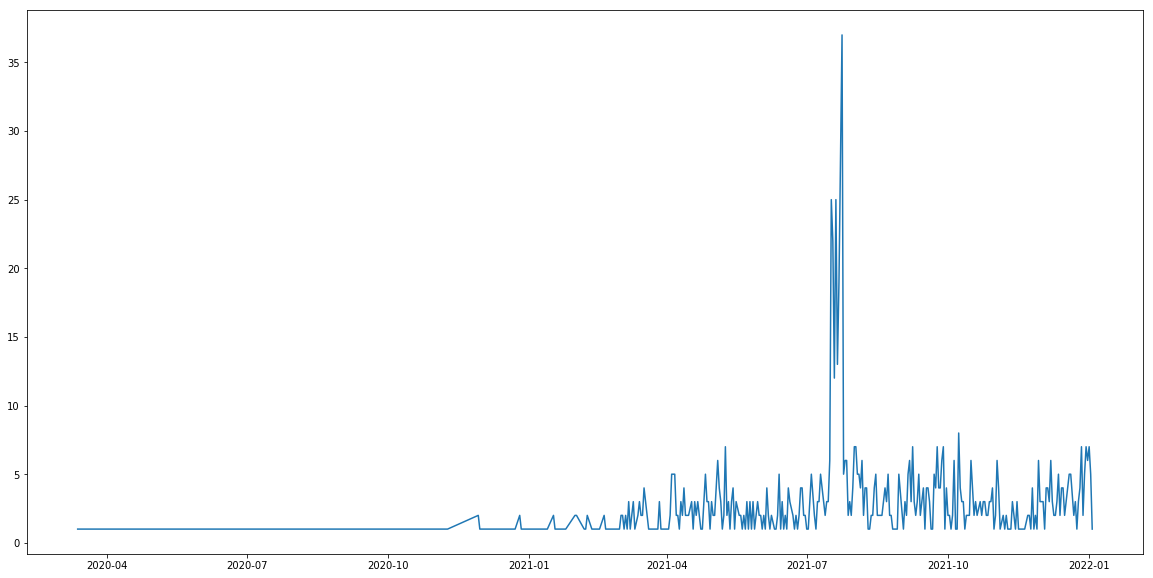

In [44]:
plt.figure(figsize=(20,10))
plt.plot(count_by_date)

In [154]:
count_by_date.where(count_by_date['count']>10).dropna()

,count
referral_date,
2021-07-17,25.0
2021-07-18,22.0
2021-07-19,12.0
2021-07-20,25.0
2021-07-21,13.0
2021-07-22,19.0
2021-07-23,28.0
2021-07-24,37.0


In [47]:
referral_count_jul = referral_date['2021-07-10':'2021-07-30'].groupby('referrer_customer_id').count()

In [157]:
len(referral_date['2021-07-01':'2021-07-31'])

254

In [68]:
referral_count_jul.sort_values(by = 'sign_up_customer_id',ascending=False).iloc[:10]

,sign_up_customer_id
referrer_customer_id,
8,7
6,4
36,3
117,2
37,2
178,2
5,1
601,1
608,1


In [111]:
temp = count_by_date.reset_index()

In [127]:
partial_records = count_by_date['2021-01-10':]

In [123]:
temp = temp.rename(columns={'referral_date':'ds','count':'y'})
m = Prophet(yearly_seasonality=True)
forecast = m.fit(temp).predict()
fig = m.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


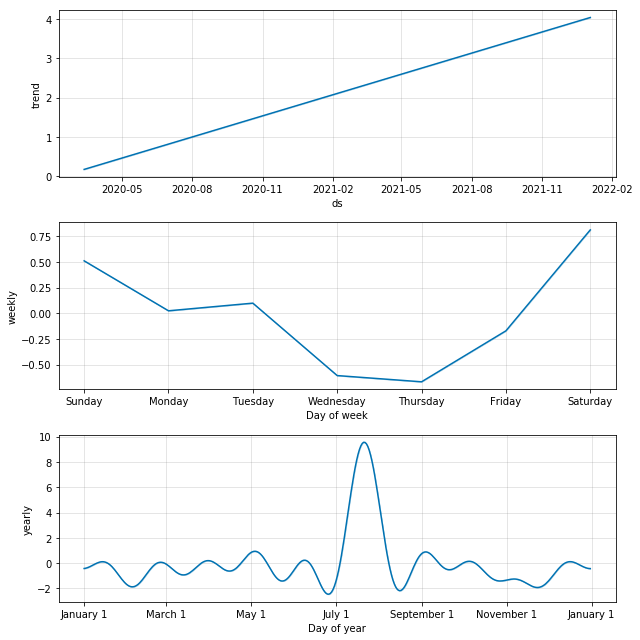

In [130]:
partial_temp = partial_records.reset_index()
partial_temp = partial_temp.rename(columns={'referral_date':'ds','count':'y'})
m = Prophet(yearly_seasonality=True)
forecast = m.fit(partial_temp).predict()
fig = m.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Q4 
Does the data suggest that the referral behaviour of Bulb members changes over time? What trends, if any, do you expect going forward? How would you measure these?

### After the peak '2021-07-31'

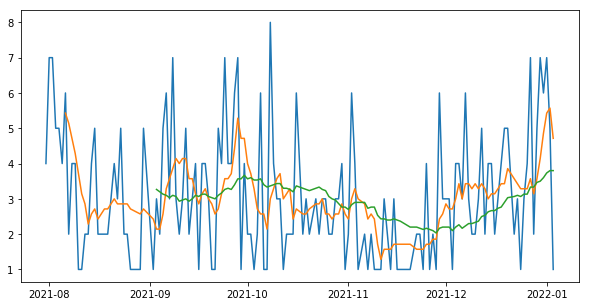

In [285]:
plt.figure(figsize=(10,5))
plt.plot(count_by_date['2021-07-31':])
plt.plot(count_by_date['2021-07-31':].rolling(7 ).mean())
plt.plot(count_by_date['2021-07-31':].rolling(30).mean())

### Before the peak '2021-07-31'

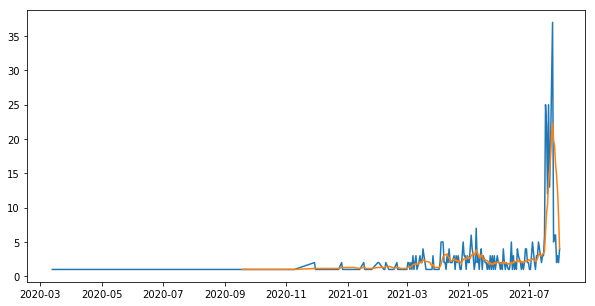

In [286]:
plt.figure(figsize=(10,5))
plt.plot(count_by_date[:'2021-07-31'])
plt.plot(count_by_date[:'2021-07-31'].rolling(7).mean())

### All the records

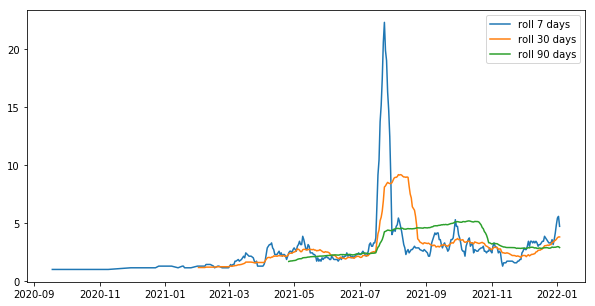

In [287]:
plt.figure(figsize=(10,5))
plt.plot(count_by_date.rolling(7).mean())
plt.plot(count_by_date.rolling(30).mean())
plt.plot(count_by_date.rolling(90).mean())
plt.legend(['roll 7 days','roll 30 days','roll 90 days'])

In [288]:
behavior_by_group = pd.merge(referral_info,customer_info,left_on='referrer_customer_id',right_on='customer_id',how='left',indicator=True).dropna()
behavior_by_group = behavior_by_group.rename(columns={'sign_up_date':'referrer_sign_up_date'}).drop(['_merge','customer_id'],axis = 1)
behavior_by_group = behavior_by_group.drop(['sign_up_customer_id','referrer_sign_up_date'],axis=1)

In [220]:
bulb_web_date = behavior_by_group[behavior_by_group['sign_up_channel'] == 'Bulb Website'].drop(['sign_up_channel'],axis=1)
bulb_web_date = bulb_web_date.groupby('referral_date').count().rename(columns={'referrer_customer_id':'count'})
ref_date = behavior_by_group[behavior_by_group['sign_up_channel'] == 'Referral'].drop(['sign_up_channel'],axis=1)
ref_date = ref_date.groupby('referral_date').count().rename(columns={'referrer_customer_id':'count'})
price_web = behavior_by_group[behavior_by_group['sign_up_channel'] == 'Price Comparison Website'].drop(['sign_up_channel'],axis=1)
price_web = price_web.groupby('referral_date').count().rename(columns={'referrer_customer_id':'count'})

In [225]:
all_behav = pd.concat([bulb_web_date,ref_date,price_web],axis=1).fillna(0)

In [289]:
all_behav.columns = ['bulb_web','refferal','price_comparison_web']

In [290]:
all_behav.tail(10)

,bulb_web,refferal,price_comparison_web
referral_date,,,
2021-12-25,1.0,1.0,1.0
2021-12-26,0.0,2.0,2.0
2021-12-27,1.0,3.0,1.0
2021-12-28,0.0,2.0,0.0
2021-12-29,1.0,1.0,1.0
2021-12-30,1.0,3.0,2.0
2021-12-31,2.0,1.0,2.0
2022-01-01,1.0,2.0,3.0
2022-01-02,0.0,3.0,0.0


In [291]:
group_all = all_behav.groupby(by=pd.Grouper(freq='M')).sum()

In [293]:
group_all

,bulb_web,refferal,price_comparison_web
referral_date,,,
2020-03-31,1.0,0.0,0.0
2020-04-30,0.0,0.0,0.0
2020-05-31,1.0,0.0,0.0
2020-06-30,1.0,0.0,0.0
2020-07-31,0.0,0.0,0.0
2020-08-31,1.0,0.0,0.0
2020-09-30,2.0,1.0,0.0
2020-10-31,1.0,2.0,0.0
2020-11-30,2.0,1.0,0.0


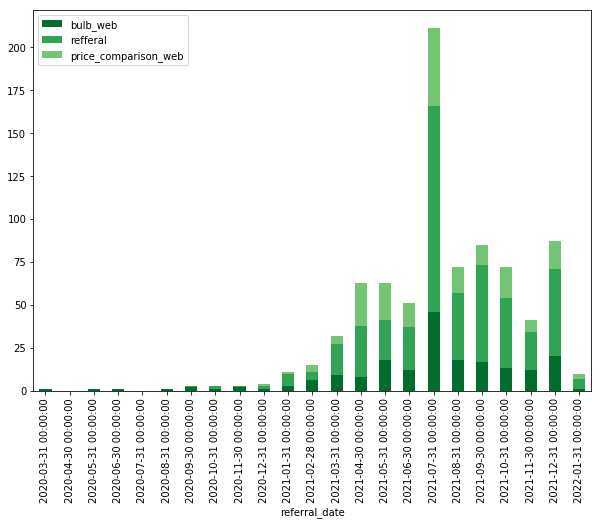

In [292]:
colors = ["#006D2C", "#31A354","#74C476"]
group_all.loc[:,['bulb_web','refferal','price_comparison_web']].plot.bar(stacked=True, color=colors, figsize=(10,7))

## Q1
When do members refer?

### Obesrvations: 
- 170 referrers are not in customer_info.csv

In [19]:
referrers_info = pd.merge(referral_info,customer_info,left_on='referrer_customer_id',right_on='customer_id',how='left',indicator=True).dropna()
referrers_info = referrers_info.rename(columns={'sign_up_date':'referrer_sign_up_date'}).drop(['_merge','customer_id'],axis = 1)

In [20]:
referrers_info.head()

,referral_date,referrer_customer_id,sign_up_customer_id,referrer_sign_up_date,sign_up_channel
0,2020-03-13,539,1469,2019-10-26,Bulb Website
1,2020-05-31,141,1015,2020-04-24,Bulb Website
3,2020-06-07,329,1222,2019-12-16,Bulb Website
4,2020-08-03,150,1025,2020-07-06,Bulb Website
5,2020-09-08,81,955,2020-09-07,Referral


In [21]:
referrers_info = referrers_info.sort_values(by=['referrer_customer_id','referral_date'])
referrers_info = referrers_info.reset_index()

In [22]:
referrers_info['{referral_date}-{sign_up}'] = referrers_info['referral_date']-referrers_info['referrer_sign_up_date']

In [23]:
referrers_info.head(15)

,index,referral_date,referrer_customer_id,sign_up_customer_id,referrer_sign_up_date,sign_up_channel,{referral_date}-{sign_up}
0,231,2021-05-29,0,869,2020-06-20,Price Comparison Website,343 days
1,951,2021-12-23,1,870,2021-10-25,Bulb Website,59 days
2,113,2021-04-10,2,871,2021-04-04,Referral,6 days
3,977,2021-12-30,3,872,2021-08-03,Price Comparison Website,149 days
4,609,2021-08-16,4,873,2020-08-20,Price Comparison Website,361 days
5,25,2021-01-17,6,889,2020-12-25,Referral,23 days
6,60,2021-03-08,6,1764,2020-12-25,Referral,73 days
7,114,2021-04-10,6,875,2020-12-25,Referral,106 days
8,176,2021-05-05,6,1308,2020-12-25,Referral,131 days
9,179,2021-05-05,6,1161,2020-12-25,Referral,131 days


### multiple referral groups 

In [24]:
pd.set_option('mode.chained_assignment', None)
duplicated_referrers = referrers_info[referrers_info['referrer_customer_id'].duplicated(keep=False)]
duplicated_referrers['shift1']= duplicated_referrers['referral_date']-duplicated_referrers['referral_date'].shift(1)

In [25]:
first_referral_ind = duplicated_referrers.groupby('referrer_customer_id').first()['index'].tolist()

In [26]:
for i in first_referral_ind:
    duplicated_referrers.loc[duplicated_referrers['index'] == i,'shift1'] = duplicated_referrers[duplicated_referrers['index'] == i]['{referral_date}-{sign_up}']

In [27]:
duplicated_referrers.head()

,index,referral_date,referrer_customer_id,sign_up_customer_id,referrer_sign_up_date,sign_up_channel,{referral_date}-{sign_up},shift1
5,25,2021-01-17,6,889,2020-12-25,Referral,23 days,23 days
6,60,2021-03-08,6,1764,2020-12-25,Referral,73 days,50 days
7,114,2021-04-10,6,875,2020-12-25,Referral,106 days,33 days
8,176,2021-05-05,6,1308,2020-12-25,Referral,131 days,25 days
9,179,2021-05-05,6,1161,2020-12-25,Referral,131 days,0 days


In [174]:
duplicated_referrers[duplicated_referrers['referrer_customer_id']==8]

,index,referral_date,referrer_customer_id,sign_up_customer_id,referrer_sign_up_date,sign_up_channel,{referral_date}-{sign_up},shift1
16,36,2021-02-07,8,1737,2020-12-30,Bulb Website,39 days,39
17,63,2021-03-10,8,1276,2020-12-30,Bulb Website,70 days,31
18,78,2021-03-20,8,1713,2020-12-30,Bulb Website,80 days,10
19,82,2021-03-26,8,1551,2020-12-30,Bulb Website,86 days,6
20,94,2021-04-04,8,1265,2020-12-30,Bulb Website,95 days,9
21,156,2021-04-28,8,1692,2020-12-30,Bulb Website,119 days,24
22,196,2021-05-11,8,1612,2020-12-30,Bulb Website,132 days,13
23,200,2021-05-13,8,1465,2020-12-30,Bulb Website,134 days,2
24,204,2021-05-14,8,1129,2020-12-30,Bulb Website,135 days,1
25,217,2021-05-22,8,881,2020-12-30,Bulb Website,143 days,8


### Original Referrral Group¶

In [28]:
multi_referral_ind = duplicated_referrers['index'].tolist()

In [29]:
for i in multi_referral_ind:
    referrers_info.loc[referrers_info['index'] == i,'{referral_date}-{sign_up}'] = duplicated_referrers[duplicated_referrers['index'] == i]['shift1']

In [31]:
referrers_info.head(15)

,index,referral_date,referrer_customer_id,sign_up_customer_id,referrer_sign_up_date,sign_up_channel,{referral_date}-{sign_up}
0,231,2021-05-29,0,869,2020-06-20,Price Comparison Website,343 days
1,951,2021-12-23,1,870,2021-10-25,Bulb Website,59 days
2,113,2021-04-10,2,871,2021-04-04,Referral,6 days
3,977,2021-12-30,3,872,2021-08-03,Price Comparison Website,149 days
4,609,2021-08-16,4,873,2020-08-20,Price Comparison Website,361 days
5,25,2021-01-17,6,889,2020-12-25,Referral,23 days
6,60,2021-03-08,6,1764,2020-12-25,Referral,50 days
7,114,2021-04-10,6,875,2020-12-25,Referral,33 days
8,176,2021-05-05,6,1308,2020-12-25,Referral,25 days
9,179,2021-05-05,6,1161,2020-12-25,Referral,0 days


### multiple referral groups

In [32]:
duplicated_referrers[['referrer_customer_id','shift1']]
duplicated_referrers['shift1'] = duplicated_referrers['shift1'].apply(lambda x : x.days)

In [33]:
dup_count = duplicated_referrers[['referrer_customer_id','shift1']].groupby('referrer_customer_id').count().rename(columns={'shift1':'count'} )

In [34]:
dup_mean = duplicated_referrers[['referrer_customer_id','shift1']].groupby('referrer_customer_id').mean().rename(columns = {'shift1':'mean'})

In [35]:
multiple_referral_mean = pd.concat([dup_count,dup_mean], axis=1).sort_values(by='count', ascending= False)

In [36]:
multiple_referral_mean.corr()

,count,mean
count,1.000000,-0.337826
mean,-0.337826,1.000000


In [ ]:
# it doesn't change much even if we remove sparse referral num
multiple_referral_mean.loc[:531].corr()
multiple_referral_mean.loc[:34].corr()

In [37]:
duplicated_referrers[['shift1']].describe()

,shift1
count,165.000000
mean,40.478788
std,56.787751
min,0.000000
25%,5.000000
50%,20.000000
75%,48.000000
max,366.000000


In [134]:
duplicated_referrers[['sign_up_channel','shift1']].groupby('sign_up_channel').describe()

shift1                                          \
                          count       mean         std  min   25%   50%   
sign_up_channel                                                           
Bulb Website               38.0  16.657895   26.617690  0.0  5.00   8.0   
Price Comparison Website   12.0  73.583333  116.468847  4.0  7.75  17.5   
Referral                  115.0  44.895652   52.689820  0.0  6.50  27.0   

                                        
                            75%    max  
sign_up_channel                         
Bulb Website              15.75  150.0  
Price Comparison Website  72.00  366.0  
Referral                  58.00  261.0

### Original Referrral Group Analysis

In [40]:
#before
referrers_info['{referral_date}-{sign_up}'].describe()

count                         830
mean      90 days 17:22:41.927710
std      109 days 02:46:54.716330
min               0 days 00:00:00
25%              11 days 00:00:00
50%              51 days 12:00:00
75%             134 days 12:00:00
max             700 days 00:00:00
Name: {referral_date}-{sign_up}, dtype: object

In [41]:
channel_vs_dates= referrers_info[['sign_up_channel','{referral_date}-{sign_up}']]
channel_vs_dates.groupby('sign_up_channel').describe()

{referral_date}-{sign_up}                            \
                                             count                      mean   
sign_up_channel                                                                
Bulb Website                                   193  107 days 13:10:52.849740   
Price Comparison Website                       188  137 days 16:12:45.957446   
Referral                                       449   63 days 19:59:27.928730   

                                                                     \
                                               std              min   
sign_up_channel                                                       
Bulb Website              132 days 09:31:00.668563  0 days 00:00:00   
Price Comparison Website  130 days 01:49:38.845077  0 days 00:00:00   
Referral                   75 days 09:37:15.188479  0 days 00:00:00   

                                                              \
                                       25%               50%   
sign_up_channel                                                
Bulb Website              12 days 00:00:00  54 days 00:00:00   
Price Comparison Website  29 days 00:00:00  98 days 12:00:00   
Referral                   6 days 00:00:00  37 days 00:00:00   

                                                                
                                        75%                max  
sign_up_channel                                                 
Bulb Website              158 days 00:00:00  700 days 00:00:00  
Price Comparison Website  193 days 18:00:00  637 days 00:00:00  
Referral                   93 days 00:00:00  453 days 00:00:00

### Special Case

In [43]:
# 2020-10-27 was referrer's last sign-up date 
referrers_info[referrers_info['referrer_customer_id']==116]

,index,referral_date,referrer_customer_id,sign_up_customer_id,referrer_sign_up_date,sign_up_channel,{referral_date}-{sign_up}
174,185,2021-05-08,116,1304,2020-05-07,Price Comparison Website,366 days
175,207,2021-05-16,116,990,2020-05-07,Price Comparison Website,8 days


## Q2 
Does the channel members are acquired from significantly impact how they refer?

In [135]:
referral_details = pd.merge(customer_info,referral_info,left_on = 'customer_id', right_on= 'referrer_customer_id' , how = 'left', indicator = True)

In [136]:
len(referral_details.dropna())

830

In [137]:
yes_referral = referral_details.dropna()

In [138]:
yes_referral = yes_referral.drop(['referrer_customer_id','sign_up_customer_id','_merge'],axis=1)

In [139]:
yes_referral_count = yes_referral.groupby('sign_up_channel').count()['customer_id']

In [140]:
yes_referral_count = yes_referral_count.sort_values()

In [158]:
yes_referral_count

sign_up_channel
Price Comparison Website    188
Bulb Website                193
Referral                    449
Name: customer_id, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11604a048>],
      dtype=object)

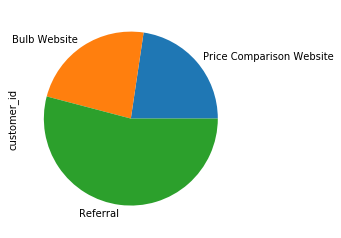

In [141]:
yes_referral_count.plot(kind='pie', subplots=True)

### conclusion
1699 customers -> 832 who did refer


In [160]:
# check
referral_details[referral_details['sign_up_date']>referral_details['referral_date']]

,customer_id,sign_up_date,sign_up_channel,referral_date,referrer_customer_id,sign_up_customer_id,_merge


In [161]:
referral_details[referral_details['sign_up_date']==referral_details['referral_date']].sort_values(by ='customer_id' )

,customer_id,sign_up_date,sign_up_channel,referral_date,referrer_customer_id,sign_up_customer_id,_merge
944,16,2021-07-04,Referral,2021-07-04,16.0,886.0,both
1161,25,2021-07-23,Referral,2021-07-23,25.0,897.0,both
1546,29,2021-10-30,Bulb Website,2021-10-30,29.0,901.0,both
1257,43,2021-08-02,Bulb Website,2021-08-02,43.0,916.0,both
1490,89,2021-09-27,Referral,2021-09-27,89.0,963.0,both
1191,98,2021-07-24,Referral,2021-07-24,98.0,972.0,both
1625,176,2021-12-12,Referral,2021-12-12,176.0,1054.0,both
858,187,2021-06-05,Referral,2021-06-05,187.0,1067.0,both
846,191,2021-05-30,Price Comparison Website,2021-05-30,191.0,1071.0,both
1175,225,2021-07-24,Bulb Website,2021-07-24,225.0,1112.0,both


In [144]:
len(referral_details[referral_details['sign_up_date']==referral_details['referral_date']])

36

### conclusion
36 sign_up_date equals to referral_date 
in these 36 ppl, 8 from Bulb Website, 1 from Price Comparison Website

In [145]:
no_referral = referral_details[referral_details['referrer_customer_id'].isna()]

In [146]:
no_referral = no_referral.drop(['referral_date','referrer_customer_id','sign_up_customer_id','_merge'],axis=1)

In [147]:
no_referral

,customer_id,sign_up_date,sign_up_channel
2,2562,2019-10-09,Bulb Website
6,2688,2019-11-11,Price Comparison Website
7,2712,2019-11-29,Price Comparison Website
8,2157,2019-11-30,Price Comparison Website
11,2485,2020-01-25,Price Comparison Website
14,2754,2020-03-31,Price Comparison Website
16,2225,2020-04-15,Price Comparison Website
17,2478,2020-04-23,Price Comparison Website
19,2465,2020-05-03,Price Comparison Website
24,1900,2020-05-13,Price Comparison Website


In [148]:
no_referral_count = no_referral.groupby('sign_up_channel').count()['customer_id']

In [149]:
no_referral_count = no_referral_count.sort_values()

In [162]:
no_referral_count

sign_up_channel
Bulb Website                195
Referral                    203
Price Comparison Website    599
Name: customer_id, dtype: int64

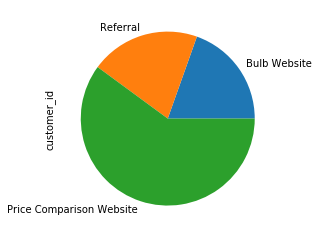

In [150]:
no_referral_count.plot(kind='pie')

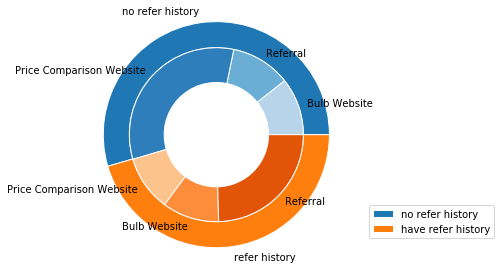

In [172]:
#outer ring
fig, ax = plt.subplots()

mypie, _ = ax.pie([997,832], radius=1.3, labels=['no refer history','refer history'] )
plt.setp( mypie, width=0.3, edgecolor='white')

#inner ring
# Create colors
b, o=[plt.cm.Blues, plt.cm.Oranges]

subgroup_names = no_referral_count.tolist()+yes_referral_count.tolist()
subgroup_size = no_referral_count.index.tolist()+yes_referral_count.index.tolist()

mypie2, _ = ax.pie(subgroup_names, radius=1.3-0.3, labels=subgroup_size,colors=[b(0.3),b(0.5),b(0.7),o(0.3),o(0.5),o(0.7)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.legend({'no refer history':997,'have refer history':832},loc="lower right",bbox_to_anchor=(1.8,0))
plt.show()


In [ ]:
no_referral_count

In [ ]:
yes_referral_count

Bulb Website 50/50
Referral double
Price Comparison Website most likely no refer 

## Community Analysis

In [294]:
first_degree_referral = pd.merge(referral_info,customer_info,left_on = 'sign_up_customer_id', right_on= 'customer_id' , how = 'inner', indicator = True)

In [295]:
first_degree_referral

,referral_date,referrer_customer_id,sign_up_customer_id,customer_id,sign_up_date,sign_up_channel,_merge
0,2021-01-31,559,632,632,2021-01-31,Referral,both
1,2021-03-14,254,857,857,2021-03-14,Referral,both
2,2021-06-25,10,425,425,2021-06-25,Referral,both
3,2021-07-24,248,271,271,2021-07-24,Referral,both
4,2021-07-24,107,260,260,2021-07-24,Referral,both
5,2021-08-01,406,261,261,2021-08-01,Referral,both
6,2021-08-22,668,442,442,2021-08-22,Referral,both
7,2021-09-05,147,1021,1021,2021-09-05,Referral,both
8,2021-09-08,71,699,699,2021-09-08,Referral,both
9,2021-09-20,214,432,432,2021-09-20,Referral,both


In [296]:
pd.merge(referral_info,referral_info,left_on = 'sign_up_customer_id', right_on= 'referrer_customer_id' , how = 'inner', indicator = True)

,referral_date_x,referrer_customer_id_x,sign_up_customer_id_x,referral_date_y,referrer_customer_id_y,sign_up_customer_id_y,_merge
0,2021-01-31,559,632,2021-07-19,632,1569,both
1,2021-03-14,254,857,2021-04-20,857,1845,both
2,2021-06-25,10,425,2021-07-31,425,1333,both
3,2021-07-24,248,271,2021-07-24,271,1158,both
4,2021-07-24,107,260,2021-07-24,260,1147,both
5,2021-08-01,406,261,2021-09-12,261,1148,both
6,2021-08-22,668,442,2021-10-24,442,1352,both
7,2021-09-08,71,699,2022-01-02,699,1647,both
8,2021-09-20,214,432,2021-09-23,432,1340,both


In [297]:
pd.merge(referral_info,customer_info,left_on = 'sign_up_customer_id', right_on= 'customer_id' , how = 'inner', indicator = True)

,referral_date,referrer_customer_id,sign_up_customer_id,customer_id,sign_up_date,sign_up_channel,_merge
0,2021-01-31,559,632,632,2021-01-31,Referral,both
1,2021-03-14,254,857,857,2021-03-14,Referral,both
2,2021-06-25,10,425,425,2021-06-25,Referral,both
3,2021-07-24,248,271,271,2021-07-24,Referral,both
4,2021-07-24,107,260,260,2021-07-24,Referral,both
5,2021-08-01,406,261,261,2021-08-01,Referral,both
6,2021-08-22,668,442,442,2021-08-22,Referral,both
7,2021-09-05,147,1021,1021,2021-09-05,Referral,both
8,2021-09-08,71,699,699,2021-09-08,Referral,both
9,2021-09-20,214,432,432,2021-09-20,Referral,both


In [299]:
first_degree_referral = first_degree_referral.rename(columns={'referrer_customer_id':'referrer_a','sign_up_customer_id':'sign_up_a'}).drop(['customer_id'],axis=1)

In [300]:
first_degree_referral = first_degree_referral.rename(columns={'referral_date':'referral_date_a','sign_up_date':'sign_up_date_a'}).drop(['sign_up_channel','_merge'],axis=1)

In [301]:
first_degree_referral = pd.merge(first_degree_referral,customer_info,left_on='referrer_a',right_on='customer_id',how = 'left', indicator=True).drop(['_merge'],axis = 1)

In [302]:
col_rename = {'referrer_a':'head_id','sign_up_date':'head_sign_up_d','sign_up_a':'a_sign_up_id',
              'sign_up_date_a':'a_sign_up_date','sign_up_channel':'haed_sign_up_channel','referral_date_a':'a_referral_date'}

In [303]:
first_degree_referral = first_degree_referral.rename(columns=col_rename)

In [304]:
first_degree_referral = first_degree_referral[['head_id','head_sign_up_d','haed_sign_up_channel','a_referral_date',
                                               'a_sign_up_id','a_sign_up_date']]

In [305]:
first_degree_referral

,head_id,head_sign_up_d,haed_sign_up_channel,a_referral_date,a_sign_up_id,a_sign_up_date
0,559,2021-01-29,Referral,2021-01-31,632,2021-01-31
1,254,NaT,NaN,2021-03-14,857,2021-03-14
2,10,2021-04-15,Referral,2021-06-25,425,2021-06-25
3,248,2021-07-20,Referral,2021-07-24,271,2021-07-24
4,107,2021-06-29,Price Comparison Website,2021-07-24,260,2021-07-24
5,406,NaT,NaN,2021-08-01,261,2021-08-01
6,668,NaT,NaN,2021-08-22,442,2021-08-22
7,147,2021-04-04,Referral,2021-09-05,1021,2021-09-05
8,71,2021-07-20,Referral,2021-09-08,699,2021-09-08
9,214,2020-07-19,Referral,2021-09-20,432,2021-09-20


In [ ]:
'''
check if merge shows correct answers
for i in [254,406,668]:
    print(i in customer_info['customer_id'].tolist())
'''

In [306]:
second_degree_referral = pd.merge(first_degree_referral,referral_info,left_on = 'a_sign_up_id', right_on= 'referrer_customer_id' , how ='left', indicator = True)

In [307]:
second_degree_referral = second_degree_referral.rename(columns={'referral_date':'b_referral_date','sign_up_customer_id':'b_sign_up_id'}).drop(['referrer_customer_id','_merge'],axis = 1)

In [308]:
second_degree_referral

,head_id,head_sign_up_d,haed_sign_up_channel,a_referral_date,a_sign_up_id,a_sign_up_date,b_referral_date,b_sign_up_id
0,559,2021-01-29,Referral,2021-01-31,632,2021-01-31,2021-07-19,1569.0
1,254,NaT,NaN,2021-03-14,857,2021-03-14,2021-04-20,1845.0
2,10,2021-04-15,Referral,2021-06-25,425,2021-06-25,2021-07-31,1333.0
3,248,2021-07-20,Referral,2021-07-24,271,2021-07-24,2021-07-24,1158.0
4,107,2021-06-29,Price Comparison Website,2021-07-24,260,2021-07-24,2021-07-24,1147.0
5,406,NaT,NaN,2021-08-01,261,2021-08-01,2021-09-12,1148.0
6,668,NaT,NaN,2021-08-22,442,2021-08-22,2021-10-24,1352.0
7,147,2021-04-04,Referral,2021-09-05,1021,2021-09-05,NaT,NaN
8,71,2021-07-20,Referral,2021-09-08,699,2021-09-08,2022-01-02,1647.0
9,214,2020-07-19,Referral,2021-09-20,432,2021-09-20,2021-09-23,1340.0


In [309]:
third_degree_referral = pd.merge(second_degree_referral ,referral_info,left_on = 'b_sign_up_id', right_on= 'referrer_customer_id' , how ='left', indicator = True)

In [311]:
third_degree_referral.dropna() 

,head_id,head_sign_up_d,haed_sign_up_channel,a_referral_date,a_sign_up_id,a_sign_up_date,b_referral_date,b_sign_up_id,referral_date,referrer_customer_id,sign_up_customer_id,_merge


In [ ]:
''' check if merge successfully
max(referral_info['referrer_customer_id'].tolist())
'''

In [471]:
net_two = second_degree_referral.drop(['head_sign_up_d','haed_sign_up_channel'],axis=1)

In [473]:
net_two['str_head_id'] = net_two['head_id'].apply(lambda x:str(x))
net_two['a_sign_up_id'] = net_two['a_sign_up_id'].apply(lambda x:str(x))
net_two['a_sign_up_date'] = net_two['a_sign_up_date'].apply(lambda x:str(x))
net_two['b_sign_up_id'] = net_two['b_sign_up_id'].apply(lambda x:str(x) )

In [317]:
import networkx as nx

/Users/joliechu/.virtualenvs/ml/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



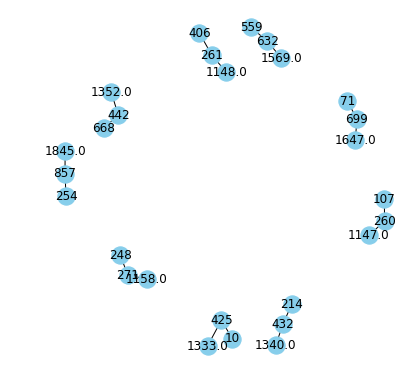

In [589]:
plt.figure(figsize=(5, 5))
G = nx.Graph()
df = pd.DataFrame({
    'from': net_two.dropna()['str_head_id'].tolist()+
    net_two.dropna()['a_sign_up_id'].tolist(),
    'to': net_two.dropna()['a_sign_up_id'].tolist()+
    net_two.dropna()['b_sign_up_id'].tolist(),
    
})
G = nx.from_pandas_edgelist(df, 'from', 'to')

nx.draw(G,
        with_labels=True,
        node_color="skyblue",
        pos = nx.spring_layout(G,k=0.3),
        min_source_margin = 0.5,
        min_target_margin= 0.5,

       )


/Users/joliechu/.virtualenvs/ml/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



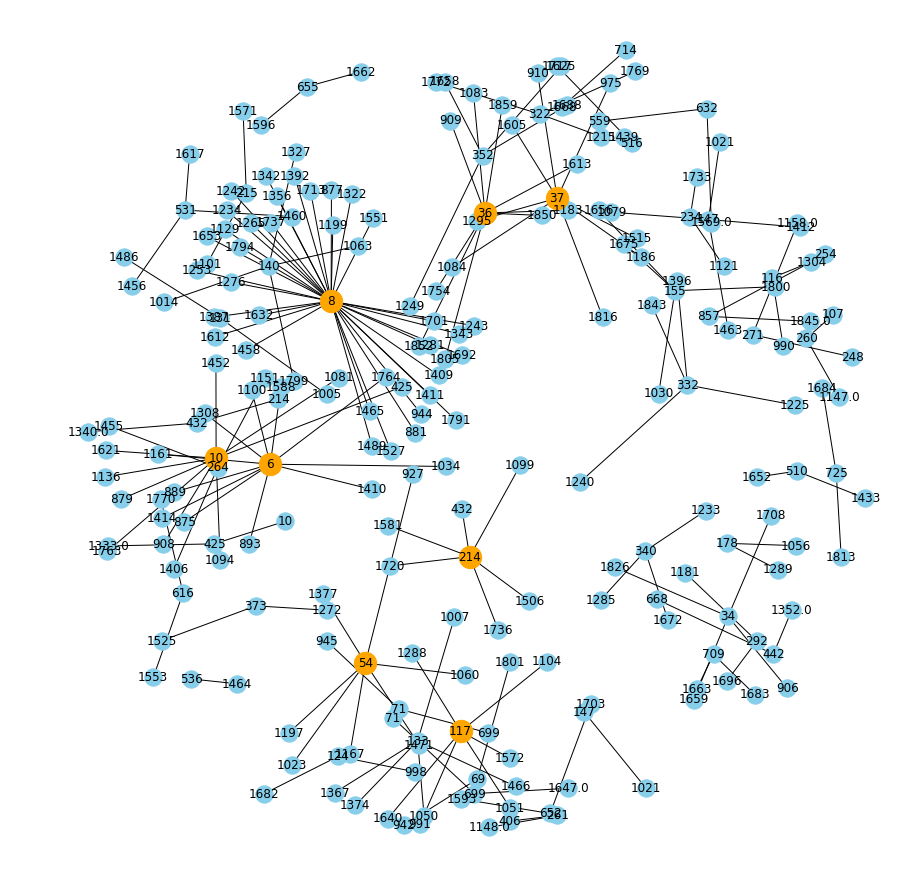

In [582]:
fig = plt.figure(figsize=(12, 12))
G = nx.Graph()
df = pd.DataFrame({
    'from': duplicated_referrers['referrer_customer_id'].tolist()+net_two['str_head_id'].tolist()+
    net_two.dropna()['a_sign_up_id'].tolist(),
    'to': duplicated_referrers['sign_up_customer_id'].tolist()+net_two['a_sign_up_id'].tolist()+
    net_two.dropna()['b_sign_up_id'].tolist(),
    
})


G = nx.from_pandas_edgelist(df, 'from', 'to')
layout = nx.spring_layout(G,k=0.25,iterations=50)
nx.draw(G,
        with_labels=True,
        node_color="skyblue",
        pos = layout,
        min_source_margin = 0.5,
        min_target_margin= 0.5,

       )

heart_of_connection = [i for i in duplicated_referrers['referrer_customer_id'].unique().tolist() if len(G[i])>5]
nx.draw_networkx_nodes(G, layout, nodelist=heart_of_connection, node_color='orange', node_size=500)


fig.savefig('temp.png', dpi=fig.dpi)